In [138]:
### uses sheet 1 from scb and  sheet åldersgrupp from fhm

#fhm_age_grp = pd.read_csv('fhm_dead_age_grp.csv',sep=';')

## NOTE! - assuming population 2020 grows as it did 2918-2019
## other prg's use mean of two consequtive years, or pop year before
## therefore this shows slightly different than eg scb_population

#### !!!!! ANOMALY in SCB data: historical death data for (at least ) 2019 from statistikdatabasen 
# http://www.statistikdatabasen.scb.se/pxweb/sv/ssd/START__BE__BE0101__BE0101G/ManadFoddDod/table/tableViewLayout1/
# does not concur with death data 2019 in the preliminary data! 

### DUE to okänd dödsdag when using the daily data of the preliminary stuff - much more okänd dag than okänd månad in 
### the monthly stuff
####

# ALL DATA BASED ON SCB PREL DATA IGNORES THOSE WITH UNKNOWN DAY OF DEATH !!!

#### BEFORE USING, check that scb and fhm have about same number of days of data

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import requests

sns.set()


In [139]:
def parse_scb_prel():
    
    def monthname2number(m):
        if m == 'januari' : return 1
        if m == 'februari' : return 2
        if m == 'mars' : return 3
        if m == 'april' : return 4
        if m == 'maj' : return 5
        if m == 'juni' : return 6
        if m == 'juli' : return 7
        if m == 'augusti' : return 8
        if m == 'september' : return 9
        if m == 'oktober' : return 10
        if m == 'november' : return 11
        if m == 'december' : return 12

    df = pd.read_csv('scb-dead_per_day.csv',sep=';',usecols=[1,2,3,4,5,6,7,10,11],thousands=' ')
    
    df['month'] = df['Månad'].apply(monthname2number)
    df[['Månad','month']] = df[['Månad','month']].replace(np.nan,0)
    df['month'] = df['month'].astype(int)
    
    unknown_death_day = df.iloc[-1,:7]
    
    df.drop(366,inplace=True)
    
    df = df.loc[df['2020'] != 0]
    
    #df = df.drop('Månad',axis=1)
    
    index = pd.date_range('2020-01-01',periods=len(df))
    df.index = index
    
    known_death_day = df.iloc[:,:7].sum()
    
    year_fraction = len(df) / 366
    
    unknown_death_day[['2015','2016','2017','2018','2019','2015-2019']] = unknown_death_day[
    ['2015','2016','2017','2018','2019','2015-2019']] * year_fraction
    
    dead_pct_per_day = df[['2015','2016','2017','2018','2019','2020','2015-2019']] / known_death_day
    
    all_deaths = df[['2015','2016','2017','2018','2019','2020','2015-2019']] + unknown_death_day * dead_pct_per_day
    
    all_deaths = pd.concat([all_deaths,df[['Månad','Dag']]],axis=1)
    
    return all_deaths

In [140]:
# SCB Excel sheet 1
scb_deaths = pd.read_csv('scb-dead_per_day.csv',sep=';',usecols=[1,2,3,4,5,6,7,10,11])
scb_deaths

,2015,2016,2017,2018,2019,2020,2015-2019,Dag,Månad
0,295,245,339,275,300,254,291,1,januari
1,272,272,317,312,276,300,290,2,januari
2,281,293,310,295,271,256,290,3,januari
3,256,260,305,285,282,272,278,4,januari
4,268,260,304,291,275,265,280,5,januari
...,...,...,...,...,...,...,...,...,...
362,274,262,273,261,215,0,257,28,december
363,292,274,276,263,244,0,270,29,december
364,283,307,275,232,226,0,265,30,december
365,255,289,302,258,246,0,270,31,december


In [141]:
scb_deaths = parse_scb_prel()
scb_deaths.rename(columns={'Dag' :'day'},inplace=True)
scb_deaths

,2015,2016,2017,2018,2019,2020,2015-2019,Månad,day
2020-01-01,298.059041,250.370762,347.270388,282.454201,309.086732,260.628770,297.585813,januari,1
2020-01-02,274.820539,277.962641,324.733667,320.457130,284.359794,307.829256,296.563181,januari,2
2020-01-03,283.913866,299.422992,317.562892,302.996325,279.208348,262.680965,296.563181,januari,3
2020-01-04,258.654625,265.699584,312.440910,292.725263,290.541528,279.098525,284.291601,januari,4
2020-01-05,270.779061,265.699584,311.416513,298.887900,283.329505,271.915842,286.336864,januari,5
...,...,...,...,...,...,...,...,...,...
2020-08-03,217.229470,209.493903,201.806096,247.532591,228.724182,175.462676,220.888438,augusti,3
2020-08-04,226.322797,250.370762,210.001267,258.830759,200.906376,143.653653,229.069492,augusti,4
2020-08-05,231.374645,231.976175,226.391610,225.963361,222.542447,73.879021,228.046860,augusti,5
2020-08-06,217.229470,218.691196,221.269628,205.421237,237.996784,33.861218,219.865807,augusti,6


In [142]:
def translate_month(m):
    if m == 'januari' : return  'January'
    if m == 'februari' : return 'February'
    if m == 'mars' : return 'March'
    if m == 'april' : return 'April'
    if m == 'maj' : return 'May'
    if m == 'juni' : return 'June'
    if m == 'juli' : return 'July'
    if m == 'augusti' : return 'August'
    if m == 'september' : return 'September'
    if m == 'oktober' : return 'October'
    if m == 'november' : return 'November'
    if m == 'december' : return 'December'
    
    
scb_deaths['month'] = scb_deaths['Månad'].apply(translate_month)

scb_deaths = scb_deaths.drop('Månad',axis=1)


scb_deaths.rename(columns={'Dag' : 'day'},inplace=True)
scb_deaths['year'] = '2020'

scb_deaths['day'] = scb_deaths['day'].astype(str)
    


In [143]:
pd.datetime.strptime('2020'+ '-'+'January'+'-'+'31','%Y-%B-%d')

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """Entry point for launching an IPython kernel.


datetime.datetime(2020, 1, 31, 0, 0)

In [144]:
def fix_date(s):
    return pd.datetime.strptime('2020'+'-'+s.month+'-'+s.day,'%Y-%B-%d')

scb_deaths['date'] = scb_deaths.apply(lambda row : fix_date(row),axis=1)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


In [145]:
scb_deaths['date'] = pd.to_datetime(scb_deaths['date'])

In [146]:
scb_deaths = scb_deaths.set_index('date')

In [147]:
scb_deaths.drop(['day','month','year'],inplace=True,axis=1)

In [148]:
last_day_mask = scb_deaths['2020'] != 0
scb_deaths = scb_deaths[last_day_mask]

scb_deaths

,2015,2016,2017,2018,2019,2020,2015-2019
date,,,,,,,
2020-01-01,298.059041,250.370762,347.270388,282.454201,309.086732,260.628770,297.585813
2020-01-02,274.820539,277.962641,324.733667,320.457130,284.359794,307.829256,296.563181
2020-01-03,283.913866,299.422992,317.562892,302.996325,279.208348,262.680965,296.563181
2020-01-04,258.654625,265.699584,312.440910,292.725263,290.541528,279.098525,284.291601
2020-01-05,270.779061,265.699584,311.416513,298.887900,283.329505,271.915842,286.336864
...,...,...,...,...,...,...,...
2020-08-03,217.229470,209.493903,201.806096,247.532591,228.724182,175.462676,220.888438
2020-08-04,226.322797,250.370762,210.001267,258.830759,200.906376,143.653653,229.069492
2020-08-05,231.374645,231.976175,226.391610,225.963361,222.542447,73.879021,228.046860


In [149]:
last_day = scb_deaths.index[-1].date()
print (last_day)
last_stable_day = (last_day - pd.DateOffset(days=7)).date()
last_stable_day

2020-08-07


datetime.date(2020, 7, 31)

In [150]:
scb_deaths['excess'] = scb_deaths['2020'] - scb_deaths['2015-2019']
scb_deaths['cumexcess'] = scb_deaths['excess'].cumsum()
scb_deaths['excess_19'] = scb_deaths['2019'] - scb_deaths['2015-2019']
scb_deaths['cumexcess_19'] = scb_deaths['excess_19'].cumsum()
scb_deaths

,2015,2016,2017,2018,2019,2020,2015-2019,excess,cumexcess,excess_19,cumexcess_19
date,,,,,,,,,,,
2020-01-01,298.059041,250.370762,347.270388,282.454201,309.086732,260.628770,297.585813,-36.957043,-36.957043,11.500920,11.500920
2020-01-02,274.820539,277.962641,324.733667,320.457130,284.359794,307.829256,296.563181,11.266075,-25.690968,-12.203387,-0.702468
2020-01-03,283.913866,299.422992,317.562892,302.996325,279.208348,262.680965,296.563181,-33.882216,-59.573185,-17.354833,-18.057301
2020-01-04,258.654625,265.699584,312.440910,292.725263,290.541528,279.098525,284.291601,-5.193076,-64.766261,6.249927,-11.807374
2020-01-05,270.779061,265.699584,311.416513,298.887900,283.329505,271.915842,286.336864,-14.421022,-79.187283,-3.007360,-14.814734
...,...,...,...,...,...,...,...,...,...,...,...
2020-08-03,217.229470,209.493903,201.806096,247.532591,228.724182,175.462676,220.888438,-45.425763,3938.635012,7.835744,-2358.036006
2020-08-04,226.322797,250.370762,210.001267,258.830759,200.906376,143.653653,229.069492,-85.415839,3853.219173,-28.163116,-2386.199122
2020-08-05,231.374645,231.976175,226.391610,225.963361,222.542447,73.879021,228.046860,-154.167839,3699.051335,-5.504413,-2391.703535


In [151]:
scb_deaths.sum()['2019'] - scb_deaths.sum()['2015-2019']

-2355.3879781420983

In [152]:
scb_deaths = scb_deaths.loc[:last_stable_day].copy()
scb_deaths

,2015,2016,2017,2018,2019,2020,2015-2019,excess,cumexcess,excess_19,cumexcess_19
date,,,,,,,,,,,
2020-01-01,298.059041,250.370762,347.270388,282.454201,309.086732,260.628770,297.585813,-36.957043,-36.957043,11.500920,11.500920
2020-01-02,274.820539,277.962641,324.733667,320.457130,284.359794,307.829256,296.563181,11.266075,-25.690968,-12.203387,-0.702468
2020-01-03,283.913866,299.422992,317.562892,302.996325,279.208348,262.680965,296.563181,-33.882216,-59.573185,-17.354833,-18.057301
2020-01-04,258.654625,265.699584,312.440910,292.725263,290.541528,279.098525,284.291601,-5.193076,-64.766261,6.249927,-11.807374
2020-01-05,270.779061,265.699584,311.416513,298.887900,283.329505,271.915842,286.336864,-14.421022,-79.187283,-3.007360,-14.814734
...,...,...,...,...,...,...,...,...,...,...,...
2020-07-27,234.405754,238.107704,256.099106,282.454201,268.905457,232.924137,255.657915,-22.733778,4160.969932,13.247542,-2305.188274
2020-07-28,243.499081,237.085782,201.806096,245.478379,222.542447,209.323894,230.092123,-20.768229,4140.201703,-7.549676,-2312.737950
2020-07-29,223.291688,235.041939,216.147646,234.180210,194.724641,204.193406,220.888438,-16.695032,4123.506671,-26.163797,-2338.901747


In [153]:
scb_deaths.sum()

2015             54692.318451
2016             53397.440952
2017             54685.354340
2018             55556.173621
2019             51896.692634
2020             58302.861010
2015-2019        54240.383185
excess            4062.477825
cumexcess       296784.428132
excess_19        -2343.690551
cumexcess_19   -318457.054926
dtype: float64

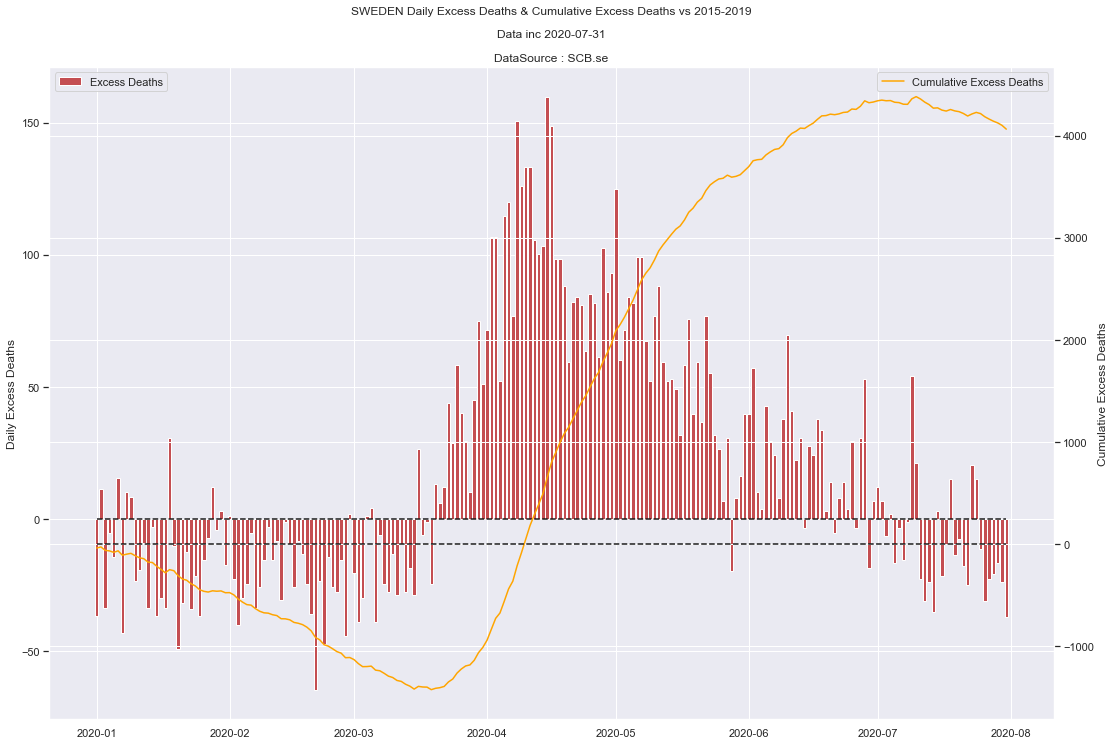

In [154]:

plt.figure(figsize=(18,12))
plt.title('SWEDEN Daily Excess Deaths & Cumulative Excess Deaths vs 2015-2019\n\nData inc {}\n\n'.format(last_stable_day)+\
         'DataSource : SCB.se')
ax = plt.gca()
ax2 = plt.twinx()
ax.bar(scb_deaths.index,scb_deaths['excess'],color='r',label='Excess Deaths')
ax.plot(scb_deaths.index,[0] * len(scb_deaths.index),color='k',ls='dashed')

ax2.plot(scb_deaths.index,scb_deaths['cumexcess'],color='orange',label='Cumulative Excess Deaths')
ax2.plot(scb_deaths.index,[0] * len(scb_deaths.index),color='k',ls='dashed')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

ax.set_ylabel('Daily Excess Deaths')
ax2.set_ylabel('Cumulative Excess Deaths')
plt.savefig('fhm_scb_excess.jpg',format='jpg')

In [155]:
### population 2015-2019
url = 'http://api.scb.se/OV0104/v1/doris/sv/ssd/START/BE/BE0101/BE0101A/BefolkningR1860'
data = {
  "query": [
    {
      "code": "Alder",
      "selection": {
        "filter": "vs:ÅlderTotA",
        "values": []
      }
    },
    {
      "code": "Kon",
      "selection": {
        "filter": "item",
        "values": [
          "1",
          "2"
        ]
      }
    },
    {
      "code": "Tid",
      "selection": {
        "filter": "item",
        "values": [
          "2015",
          "2016",
          "2017",
          "2018",
          "2019"
        ]
      }
    }
  ],
  "response": {
    "format": "json"
  }
}

In [156]:
r = requests.post(url,json=data)
r.status_code

200

In [157]:
json = r.json()

In [158]:
json['data'][0]

{'key': ['1', '2015'], 'values': ['4930966']}

In [159]:
data_list = []

for rec in range(len(json['data'])):
    data_list.append((json['data'][rec]['key'][0],json['data'][rec]['key'][1],json['data'][rec]['values'][0]))

In [160]:
population = pd.DataFrame(data_list,columns=['gender','year','population'])
population = population.set_index('year')
population['population'] = population['population'].astype(int)

In [161]:
population

,gender,population
year,,
2015,1,4930966
2016,1,5013347
2017,1,5082662
2018,1,5142438
2019,1,5195814
2015,2,4920051
2016,2,4981806
2017,2,5037580
2018,2,5087747


In [162]:
population = population.groupby(population.index).sum()
population['growth'] = population['population'] / population['population'].shift()


population.loc['2020','population'] = population.loc['2019','population']  
population['population'] = population['population'].astype(int)
population

,population,growth
year,,
2015,9851017,NaN
2016,9995153,1.014632
2017,10120242,1.012515
2018,10230185,1.010864
2019,10327589,1.009521
2020,10327589,NaN


In [163]:
scb_deaths_ytd = scb_deaths.sum()
scb_deaths_ytd = scb_deaths_ytd.drop(['2015-2019','excess','cumexcess'])
scb_deaths_ytd

2015             54692.318451
2016             53397.440952
2017             54685.354340
2018             55556.173621
2019             51896.692634
2020             58302.861010
excess_19        -2343.690551
cumexcess_19   -318457.054926
dtype: float64

In [164]:
deaths_per_M_ytd = scb_deaths_ytd / (population['population'] / 1e6)
deaths_per_M_ytd

2015            5551.946408
2016            5342.333524
2017            5403.561925
2018            5430.612801
2019            5025.054021
2020            5645.350624
cumexcess_19            NaN
excess_19               NaN
dtype: float64

In [165]:
scb_deaths

,2015,2016,2017,2018,2019,2020,2015-2019,excess,cumexcess,excess_19,cumexcess_19
date,,,,,,,,,,,
2020-01-01,298.059041,250.370762,347.270388,282.454201,309.086732,260.628770,297.585813,-36.957043,-36.957043,11.500920,11.500920
2020-01-02,274.820539,277.962641,324.733667,320.457130,284.359794,307.829256,296.563181,11.266075,-25.690968,-12.203387,-0.702468
2020-01-03,283.913866,299.422992,317.562892,302.996325,279.208348,262.680965,296.563181,-33.882216,-59.573185,-17.354833,-18.057301
2020-01-04,258.654625,265.699584,312.440910,292.725263,290.541528,279.098525,284.291601,-5.193076,-64.766261,6.249927,-11.807374
2020-01-05,270.779061,265.699584,311.416513,298.887900,283.329505,271.915842,286.336864,-14.421022,-79.187283,-3.007360,-14.814734
...,...,...,...,...,...,...,...,...,...,...,...
2020-07-27,234.405754,238.107704,256.099106,282.454201,268.905457,232.924137,255.657915,-22.733778,4160.969932,13.247542,-2305.188274
2020-07-28,243.499081,237.085782,201.806096,245.478379,222.542447,209.323894,230.092123,-20.768229,4140.201703,-7.549676,-2312.737950
2020-07-29,223.291688,235.041939,216.147646,234.180210,194.724641,204.193406,220.888438,-16.695032,4123.506671,-26.163797,-2338.901747


In [166]:
scb_deaths.loc['2020-01-01' : '2020-07-31','2019'].sum()

51896.69263439765

In [167]:
population

,population,growth
year,,
2015,9851017,NaN
2016,9995153,1.014632
2017,10120242,1.012515
2018,10230185,1.010864
2019,10327589,1.009521
2020,10327589,NaN


In [168]:
scb_deaths.loc['2020-01-01' : '2020-07-31','2019'].sum()

51896.69263439765

In [169]:
scb_deaths.loc['2020-01-01' : '2020-07-31','2019'].sum() / population.loc['2019','population']

0.005025054021262625

In [170]:
maximums = pd.concat ([scb_deaths.max(),
            pd.Series(scb_deaths.index[scb_deaths.apply(np.argmax)].values,
                      index=scb_deaths.max().index)],axis=1)
maximums.columns = ['max','date_of_max']
maximums

,max,date_of_max
2015,340.494565,2020-02-20
2016,322.927186,2020-01-25
2017,347.270388,2020-01-01
2018,344.080572,2020-02-26
2019,309.086732,2020-01-01
2020,408.386812,2020-04-15
2015-2019,298.608444,2020-02-20
excess,159.887319,2020-04-15
cumexcess,4380.585167,2020-07-10
excess_19,29.663251,2020-04-19


In [171]:
minimums = pd.concat ([scb_deaths.min(),
            pd.Series(scb_deaths.index[scb_deaths.apply(np.argmin)].values,
                      index=scb_deaths.min().index)],axis=1)
minimums.columns = ['min','date_of_min']
minimums

,min,date_of_min
2015,0.000000,2020-02-29
2016,191.099316,2020-06-06
2017,0.000000,2020-02-29
2018,0.000000,2020-02-29
2019,0.000000,2020-02-29
2020,193.932431,2020-07-22
2015-2019,208.616858,2020-06-11
excess,-64.661676,2020-02-21
cumexcess,-1422.511975,2020-03-19
excess_19,-248.499493,2020-02-29


In [172]:
daily_deaths_per_M = scb_deaths.loc[:,'2015' : '2020'].div(population['population'] / 1e6,axis=1)
daily_deaths_per_M 

,2015,2016,2017,2018,2019,2020
date,,,,,,
2020-01-01,30.256677,25.049218,34.314435,27.609882,29.928256,25.236168
2020-01-02,27.897682,27.809744,32.087540,31.324666,27.533996,29.806497
2020-01-03,28.820767,29.956819,31.378982,29.617873,27.035192,25.434878
2020-01-04,26.256642,26.582843,30.872869,28.613878,28.132561,27.024558
2020-01-05,27.487422,26.582843,30.771647,29.216275,27.434235,26.329073
...,...,...,...,...,...,...
2020-07-27,23.795082,23.822317,25.305631,27.609882,26.037583,22.553583
2020-07-28,24.718167,23.720075,19.940837,23.995497,21.548345,20.268418
2020-07-29,22.666867,23.515592,21.357952,22.891102,18.854802,19.771643


In [173]:
daily_deaths_per_M.sum()

2015    5551.946408
2016    5342.333524
2017    5403.561925
2018    5430.612801
2019    5025.054021
2020    5645.350624
dtype: float64

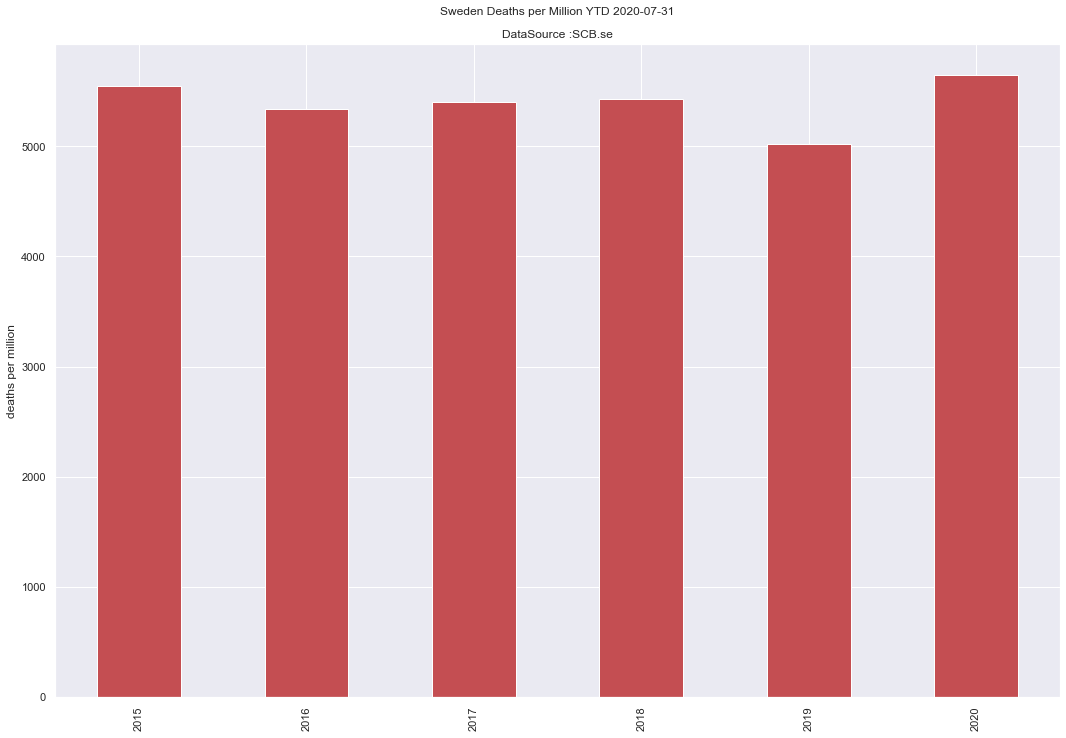

In [174]:
daily_deaths_per_M.sum().plot(kind='bar',
                              figsize=(18,12),
                              color='r',
                              title='Sweden Deaths per Million YTD {}\n\nDataSource :SCB.se'.format(last_stable_day))
plt.ylabel('deaths per million')
plt.savefig('fhm_scb_deaths_per_M.jpg',format='jpg')

In [175]:
daily_deaths_per_M_2015_2019_avg = daily_deaths_per_M[['2015','2016','2017','2018','2019']].mean(axis=1)
daily_deaths_per_M_2015_2019_avg

date
2020-01-01    29.431694
2020-01-02    29.330725
2020-01-03    29.361927
2020-01-04    28.091759
2020-01-05    28.298484
                ...    
2020-07-27    25.314099
2020-07-28    22.784584
2020-07-29    21.857263
2020-07-30    22.289247
2020-07-31    23.385063
Length: 213, dtype: float64

Text(0, 0.5, 'deaths per million per day')

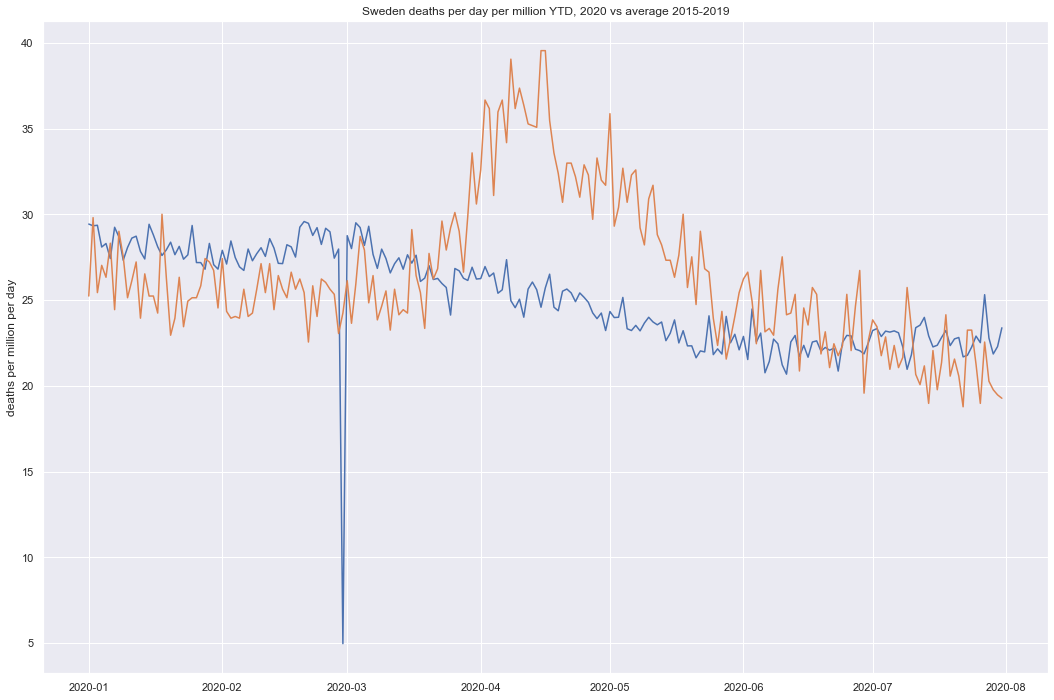

In [176]:
plt.figure(figsize=(18,12))
plt.plot(daily_deaths_per_M_2015_2019_avg)
plt.plot(daily_deaths_per_M['2020'])
plt.title('Sweden deaths per day per million YTD, 2020 vs average 2015-2019')
plt.ylabel('deaths per million per day')

In [177]:
import calendar
d = dict(enumerate(calendar.month_abbr))

In [178]:
monthly_deaths_per_M = daily_deaths_per_M.groupby(daily_deaths_per_M.index.month).sum()
month_names = pd.Series(monthly_deaths_per_M.index.values).map(d)
month_names
monthly_deaths_per_M.index = month_names
monthly_deaths_per_M.index.name = 'month'
monthly_deaths_per_M

,2015,2016,2017,2018,2019,2020
month,,,,,,
Jan,885.853968,873.962087,921.226178,861.227521,815.445228,806.762532
Feb,827.391914,784.398354,797.127366,818.356904,727.655676,731.451448
Mar,884.007798,818.853808,817.473093,924.680050,755.189671,831.005150
Apr,789.135166,757.202061,765.849606,764.542734,716.881503,1030.013198
May,749.852768,714.771754,742.163536,680.508293,695.532680,864.388427
Jun,694.057404,668.865228,673.635888,652.496813,643.657036,716.945620
Jul,721.647391,724.280232,686.086258,728.800487,670.692227,664.784249


In [179]:
monthly_deaths_per_M.sum()

2015    5551.946408
2016    5342.333524
2017    5403.561925
2018    5430.612801
2019    5025.054021
2020    5645.350624
dtype: float64

In [180]:
ytd_deaths_per_M_avg = monthly_deaths_per_M.loc[:,:'2019'].sum().mean()
ytd_deaths_per_M_avg

5350.701735970435

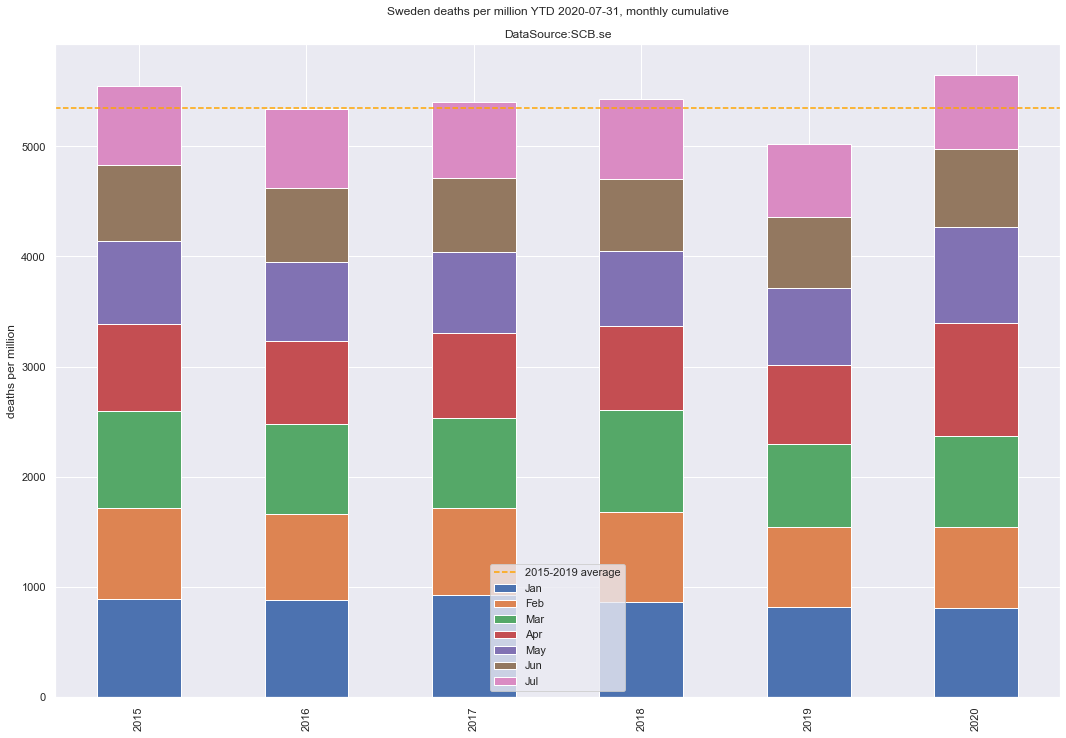

In [181]:
monthly_deaths_per_M.T.plot(kind='bar',
                            stacked=True,figsize=(18,12),
                           title='Sweden deaths per million YTD {}, monthly cumulative\n\nDataSource:SCB.se'.format(
                               last_stable_day))
plt.ylabel('deaths per million')
plt.axhline(ytd_deaths_per_M_avg,ls='dashed',color='orange',label='2015-2019 average')
plt.legend(loc='lower center')

In [182]:
# FHM excel sheed döda åldersgrupp
fhm_age_grp = pd.read_csv('fhm_dead_age_grp.csv',sep=';')
age_grp = ['0-9','10-19','20-29','30-39','40-49','50-59','60-69','70-79','80-89','90+']
fhm_age_grp.drop('Åldersgrupp',axis=1,inplace=True)
fhm_cols = ['cases','icu','dead']
fhm_age_grp.columns = fhm_cols
fhm_age_grp['age_grp'] = age_grp
fhm_age_grp.set_index('age_grp',inplace=True,drop=True)
fhm_age_grp

,cases,icu,dead
age_grp,,,
0-9,525,8,1
10-19,3466,15,0
20-29,12587,92,9
30-39,12728,116,16
40-49,13729,282,44
50-59,14778,644,161
60-69,8463,762,398
70-79,5926,501,1241
80-89,6561,103,2392


In [183]:
print (fhm_age_grp.sum())
scb_deaths['2020'].sum()

cases    82305
icu       2527
dead      5763
dtype: int64


58302.86100989068

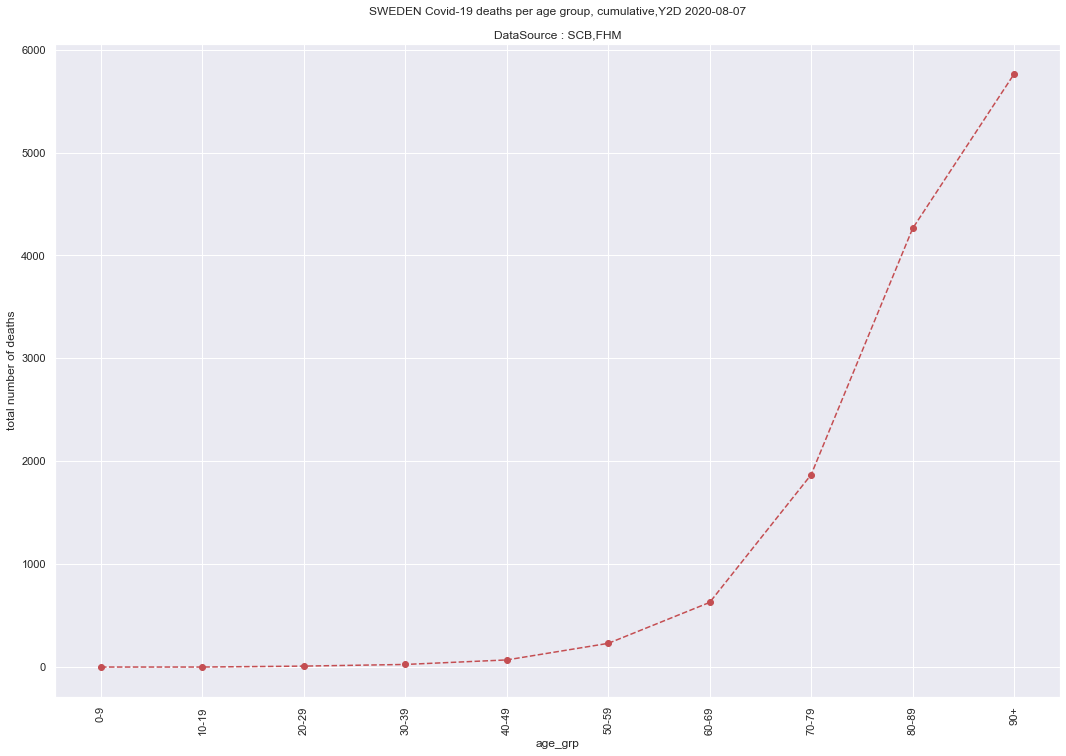

In [184]:
fhm_age_grp['dead'].cumsum().plot(style='ro--',
                                  title='SWEDEN Covid-19 deaths per age group, cumulative,Y2D {}\n\nDataSource : SCB,FHM'.format(last_day),
                                  figsize=(18,12))
plt.ylabel('total number of deaths')
_= plt.xticks(range(len(fhm_age_grp)),age_grp,rotation=90)
plt.savefig('fhm_scb_cumulative_covid_deaths.jpg',format='jpg')

In [185]:
# population stratified

url2 = 'http://api.scb.se/OV0104/v1/doris/sv/ssd/START/BE/BE0101/BE0101A/BefolkningR1860'

data2 = {
  "query": [
    {
      "code": "Alder",
      "selection": {
        "filter": "vs:Ålder1årA",
        "values": [
          "0",
          "1",
          "2",
          "3",
          "4",
          "5",
          "6",
          "7",
          "8",
          "9",
          "10",
          "11",
          "12",
          "13",
          "14",
          "15",
          "16",
          "17",
          "18",
          "19",
          "20",
          "21",
          "22",
          "23",
          "24",
          "25",
          "26",
          "27",
          "28",
          "29",
          "30",
          "31",
          "32",
          "33",
          "34",
          "35",
          "36",
          "37",
          "38",
          "39",
          "40",
          "41",
          "42",
          "43",
          "44",
          "45",
          "46",
          "47",
          "48",
          "49",
          "50",
          "51",
          "52",
          "53",
          "54",
          "55",
          "56",
          "57",
          "58",
          "59",
          "60",
          "61",
          "62",
          "63",
          "64",
          "65",
          "66",
          "67",
          "68",
          "69",
          "70",
          "71",
          "72",
          "73",
          "74",
          "75",
          "76",
          "77",
          "78",
          "79",
          "80",
          "81",
          "82",
          "83",
          "84",
          "85",
          "86",
          "87",
          "88",
          "89",
          "90",
          "91",
          "92",
          "93",
          "94",
          "95",
          "96",
          "97",
          "98",
          "99",
          "100+"
        ]
      }
    },
    {
      "code": "Kon",
      "selection": {
        "filter": "item",
        "values": [
          "1",
          "2"
        ]
      }
    },
    {
      "code": "Tid",
      "selection": {
        "filter": "item",
        "values": [
          "2019"
        ]
      }
    }
  ],
  "response": {
    "format": "json"
  }
}

In [186]:
r2 = requests.post(url2,json=data2)
r2.status_code

200

In [187]:
json2 = r2.json()
json2['data'][0]

{'key': ['0', '1', '2019'], 'values': ['59476']}

In [188]:
data2_list = []

for rec2 in range(len(json2['data'])):
    
    data2_list.append((json2['data'][rec2]['key'][0],json2['data'][rec2]['key'][1],json2['data'][rec2]['key'][2],
                      json2['data'][rec2]['values'][0]))

In [189]:
population_age_grp = pd.DataFrame(data=data2_list,columns=['age_grp','gender','year','pop'])
population_age_grp['pop'] = population_age_grp['pop'].astype(int)
population_age_grp['age_grp'] = population_age_grp['age_grp'].apply(lambda s : s.replace('+',''))
population_age_grp['age_grp'] = population_age_grp['age_grp'].astype(int)
population_age_grp

,age_grp,gender,year,pop
0,0,1,2019,59476
1,0,2,2019,55907
2,1,1,2019,60993
3,1,2,2019,57783
4,2,1,2019,61598
...,...,...,...,...
197,98,2,2019,2126
198,99,1,2019,377
199,99,2,2019,1477
200,100,1,2019,375


In [190]:
population_age_grp = pd.pivot_table(population_age_grp,index='age_grp',columns='gender',values='pop')
population_age_grp

gender,1,2
age_grp,,
0,59476,55907
1,60993,57783
2,61598,58432
3,63965,60716
4,63535,59313
...,...,...
96,1372,3869
97,917,2738
98,583,2126


In [191]:
population_age_grp['pop'] = population_age_grp.sum(axis=1)
population_age_grp.drop(['1','2'],axis=1,inplace=True)


In [192]:
population_age_grp = pd.Series(population_age_grp['pop'])
population_age_grp

age_grp
0      115383
1      118776
2      120030
3      124681
4      122848
        ...  
96       5241
97       3655
98       2709
99       1854
100      2207
Name: pop, Length: 101, dtype: int64

In [193]:
population_age_grp.loc['30':'39'].sum()

1366489

In [194]:
population_age_grp

age_grp
0      115383
1      118776
2      120030
3      124681
4      122848
        ...  
96       5241
97       3655
98       2709
99       1854
100      2207
Name: pop, Length: 101, dtype: int64

In [195]:
zero_9 = pd.Series(population_age_grp.loc[0:9].sum())
ten_19 = pd.Series(population_age_grp.loc[10:19].sum())
twenty_29 = pd.Series(population_age_grp.loc[20:29].sum())
thirty_39 = pd.Series(population_age_grp.loc[30:39].sum())
forty_49 = pd.Series(population_age_grp.loc[40:49].sum())
fifty_59 = pd.Series(population_age_grp.loc[50:59].sum())
sixty_69 = pd.Series(population_age_grp.loc[60:69].sum())
seventy_79 = pd.Series(population_age_grp.loc[70:79].sum())
eighty_89 = pd.Series(population_age_grp.loc[80:89].sum())
ninety_plus = pd.Series(population_age_grp.loc[90:].sum())

thirty_39

0    1366489
dtype: int64

In [196]:
population_age_grp = pd.DataFrame([zero_9,ten_19,twenty_29,thirty_39,forty_49,fifty_59,
                               sixty_69,seventy_79,eighty_89,ninety_plus],index=age_grp)

population_age_grp.rename(columns={0:'pop'},inplace=True)

population_age_grp

,pop
0-9,1225802
10-19,1177928
20-29,1327395
30-39,1366489
40-49,1298355
50-59,1297863
60-69,1108438
70-79,989013
80-89,436679
90+,99627


In [197]:
population_age_grp['pop'].sum()

10327589

In [198]:
population_age_grp

,pop
0-9,1225802
10-19,1177928
20-29,1327395
30-39,1366489
40-49,1298355
50-59,1297863
60-69,1108438
70-79,989013
80-89,436679
90+,99627


In [199]:
fhm_age_grp

,cases,icu,dead
age_grp,,,
0-9,525,8,1
10-19,3466,15,0
20-29,12587,92,9
30-39,12728,116,16
40-49,13729,282,44
50-59,14778,644,161
60-69,8463,762,398
70-79,5926,501,1241
80-89,6561,103,2392


In [200]:
covid_dead_per_age_grp = fhm_age_grp['dead'] / population_age_grp['pop']
covid_dead_per_age_grp

age_grp
0-9      8.157924e-07
10-19    0.000000e+00
20-29    6.780197e-06
30-39    1.170884e-05
40-49    3.388904e-05
50-59    1.240501e-04
60-69    3.590638e-04
70-79    1.254786e-03
80-89    5.477708e-03
90+      1.506620e-02
dtype: float64

Text(0, 0.5, 'percent of age group')

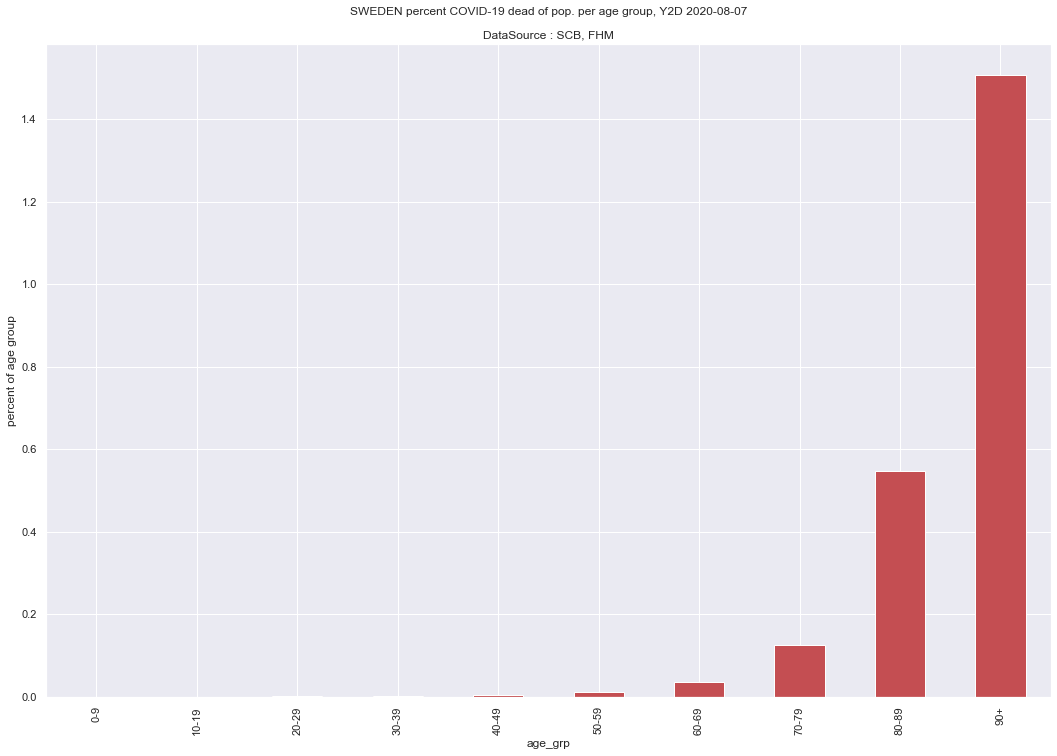

In [201]:
(100 * covid_dead_per_age_grp).plot(kind='bar',color='r',figsize=(18,12),
                                    title='SWEDEN percent COVID-19 dead of pop. per age group, Y2D {}\n\nDataSource : SCB, FHM'.format(last_day))
plt.ylabel('percent of age group')
#plt.yscale('log')

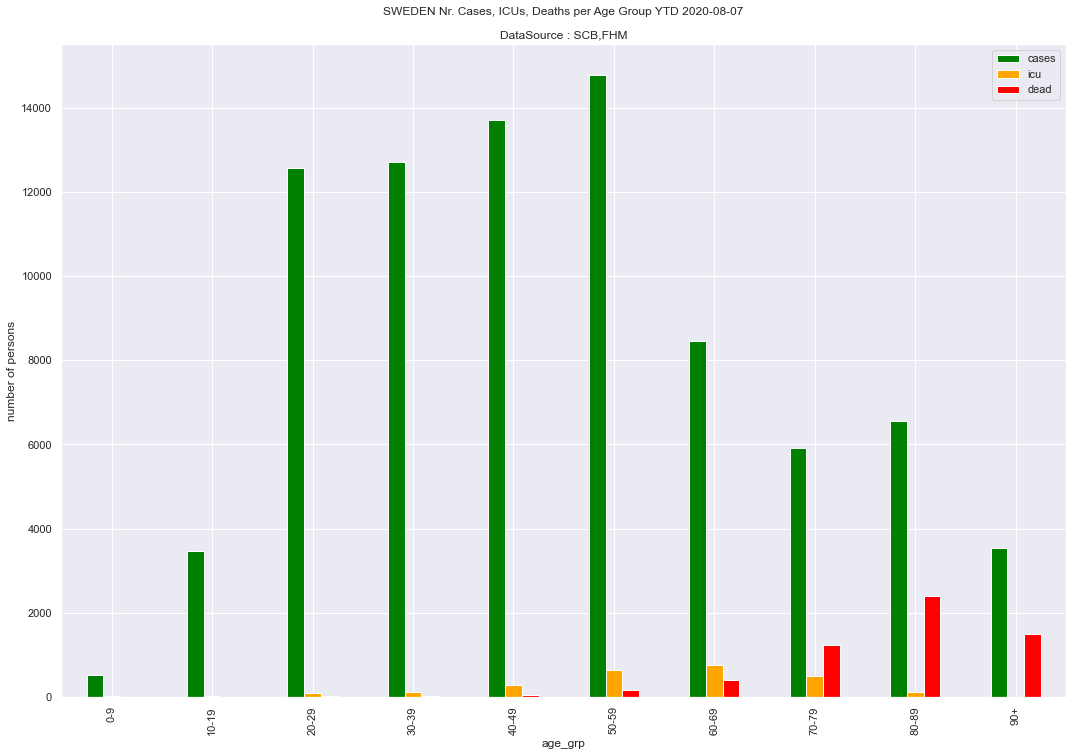

In [202]:
fhm_age_grp.plot(kind='bar',
                 figsize=(18,12),
                 color=['green','orange','red'],
                title='SWEDEN Nr. Cases, ICUs, Deaths per Age Group YTD {}\n\nDataSource : SCB,FHM'.format(last_day))
plt.ylabel('number of persons')
plt.savefig('fhm_case_icu_deaths.jpg',format='jpg')

In [203]:
fhm_data_per_age_group_capita = fhm_age_grp.div(population_age_grp['pop'],axis=0)
fhm_data_per_age_group_capita

,cases,icu,dead
age_grp,,,
0-9,0.000428,0.000007,8.157924e-07
10-19,0.002942,0.000013,0.000000e+00
20-29,0.009482,0.000069,6.780197e-06
30-39,0.009314,0.000085,1.170884e-05
40-49,0.010574,0.000217,3.388904e-05
50-59,0.011386,0.000496,1.240501e-04
60-69,0.007635,0.000687,3.590638e-04
70-79,0.005992,0.000507,1.254786e-03
80-89,0.015025,0.000236,5.477708e-03


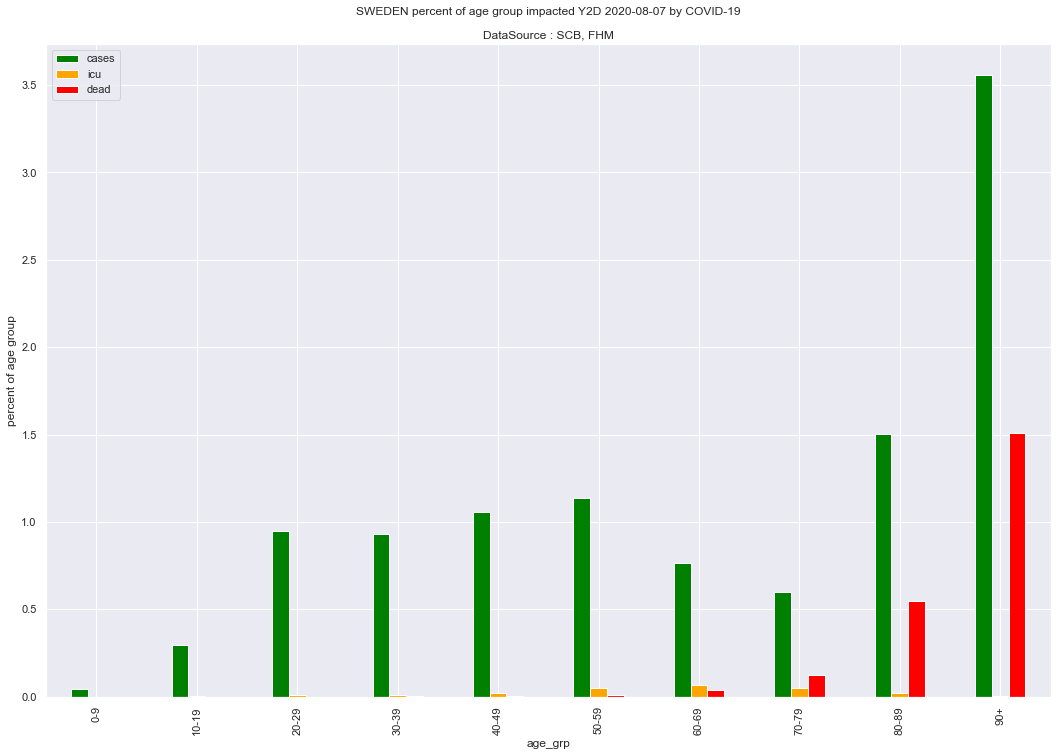

In [204]:
(100 * fhm_data_per_age_group_capita).plot(kind='bar',title='SWEDEN percent of age group impacted Y2D {} by COVID-19\n\nDataSource : SCB, FHM'.format(last_day),
                                           figsize=(18,12),color=['green','orange','red'])
plt.ylabel('percent of age group')
plt.savefig('fhm_pct_age_grp_impacted.jpg',format='jpg')